## Step 0: Import Statements & Constants

In [1]:
import cv2
import numpy as np
import pdb
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

## Step 1: Derive Positions

#### Measure Position from Raw Footage

In [2]:
# V_CALIBRATION  = 0
# H_CALIBRATION  = 0

# # FLIR: workspace box bounded to real world coordinates of: upper left: (-0.3", 0.3") to bottom right: (4.4", 3.2")
# PIX_RANGE_X    = 1024
# PIX_RANGE_Y    = 1024
# MIN_X_PIX      = 0
# MAX_X_PIX      = MIN_X_PIX + PIX_RANGE_X
# MIN_Y_PIX      = 0
# MAX_Y_PIX      = MIN_Y_PIX + PIX_RANGE_Y
# WORLD_ORIGIN_TRANSLATION = 0
# WIDTH_IN_INCHES = 3.7
# PIX_TO_IN      = WIDTH_IN_INCHES / PIX_RANGE_X

# '''
# camera field of view offsets:
# 1024x1024, x-offset: 700, y-offset: 226
# '''

# # SIZE_IN_INCHES = 5.9
# # PIX_TO_IN      = SIZE_IN_INCHES / PIX_RANGE

# frame_count = 0
# background_frame = None
# # cap = cv2.VideoCapture(1)
# cap = cv2.VideoCapture('90fps-um.avi')

# # Open a CSV file for writing
# with open('um-positions.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(["h_pos", "v_pos"])  # Write header

#     start_time = time.time()
#     while True:
#         ret, frame = cap.read()
#         frame_count += 1
#         if not ret:
#             break
        
#         # Crop whole frame to target workspace area:
#         # [Y, X] components respectively, given the current orientation of the camera
#         workspace_frame = frame[MIN_Y_PIX : MAX_Y_PIX, MIN_X_PIX : MAX_X_PIX]

#         gray = cv2.cvtColor(workspace_frame, cv2.COLOR_BGR2GRAY)
#         gray = cv2.GaussianBlur(gray, (35, 35), 0)  # Filter for noise between frames

#         if background_frame is None:
#             background_frame = gray

#         frame_delta = cv2.absdiff(background_frame, gray)

#         # If any pixel intensity is < 25, set to 0. If > 25, set to 255
#         # Average over 6 iterations
#         _, thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)
#         thresh = cv2.dilate(thresh, None, iterations=6)

#         # Note contours x,y positions are defined based on the cropped frame!
#         contours, heirarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         for cnt in contours:
#             x, y, w, h = cv2.boundingRect(cnt)
#             h_pos = ((x + w/2) - WORLD_ORIGIN_TRANSLATION) * PIX_TO_IN
#             v_pos = (-1 * ((y + h/2) - WORLD_ORIGIN_TRANSLATION)) * PIX_TO_IN
#             print(round(h_pos, 2), round(v_pos, 2))
#             writer.writerow([round(h_pos, 2), round(v_pos, 2)])  # Write positions to CSV

#         # cv2.imshow('gray', gray)
#         cv2.imshow('color', workspace_frame)
#         cv2.imshow('threshold', thresh)
#         # print(frame.shape)  # 1080 * 1920 * 3 (rgb) -> (255, 255, 255)

#         cv2.imshow('frame', frame)
#         k = cv2.waitKey(5)
#         if k == 27:
#             break

# end_time = time.time()
# print(frame_count)
# print(end_time - start_time)
# cv2.destroyAllWindows()


#### Split Positions into Action Segments: A to B and B to A

In [96]:
# Load the data from the provided CSV file
data = pd.read_csv('ur-positions.csv')

# Define the positions A and B and the tolerance
position_A = np.array([2.31, -0.79])
position_B = np.array([1.52, -1.58])
tolerance = 0.2
repeating_threshold = 50

# def is_same_point(a, b):
#     return np.linalg.norm(b - a) <= SAME_POINT_THRESHOLD

# Function to check if a position is within tolerance of a target position using Euclidean distance
def is_within_tolerance(pos, target, tol):
    return np.sqrt((pos[0] - target[0])**2 + (pos[1] - target[1])**2) <= tol

# Initialize variables
segments = []
current_segment = []
recording = False
repeating_count_A = 0
repeating_count_B = 0
last_pos_A = None
last_pos_B = None

for index, row in data.iterrows():
    pos = [row['h_pos'], row['v_pos']]
    
    if is_within_tolerance(pos, position_A, tolerance):
        if last_pos_A is not None and np.allclose(pos, last_pos_A, atol=tolerance):
            repeating_count_A += 1
        else:
            repeating_count_A = 1
        last_pos_A = pos
    else:
        repeating_count_A = 0
        last_pos_A = None

    if recording:
        current_segment.append(row)
        
        if is_within_tolerance(pos, position_B, tolerance):
            if last_pos_B is not None and np.allclose(pos, last_pos_B, atol=tolerance):
                repeating_count_B += 1
            else:
                repeating_count_B = 1
            last_pos_B = pos

            if repeating_count_B >= repeating_threshold:
                segments.append(pd.DataFrame(current_segment))
                current_segment = []
                recording = False
                repeating_count_B = 0
                last_pos_B = None
        else:
            repeating_count_B = 0
            last_pos_B = None

    if repeating_count_A >= repeating_threshold and not recording:
        recording = True
        current_segment = [row]

# Save each segment to a CSV file
for i, segment in enumerate(segments):
    segment.to_csv(f'segment_{i+1}.csv', index=False)

print(f'Total segments created: {len(segments)}')


Total segments created: 10


#### Plot Position of a Single Action

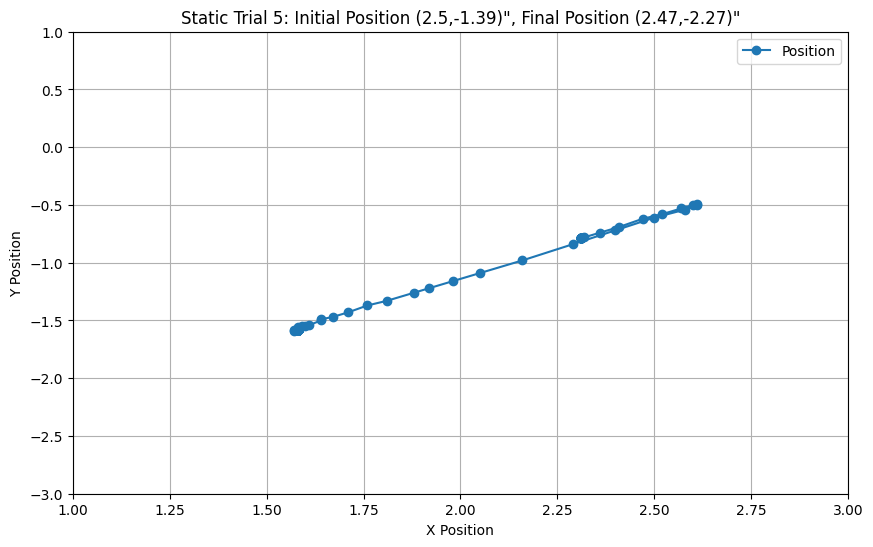

In [230]:
file_path = 'ur/center_to_ur/segment_1.csv'
df = pd.read_csv(file_path)

# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(df['h_pos'], df['v_pos'], 'o-', label='Position')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Static Trial 5: Initial Position (2.5,-1.39)", Final Position (2.47,-2.27)"')

# Set the x-axis range to show from 0 to 5
plt.xlim([1, 3])

# Set the y-axis range to show from -3.5 to -2
plt.ylim([-3, 1])

plt.legend()
plt.grid(True)
plt.show()

## Step 2: Derive Velocity & Acceleration for Each Segment

#### Organize Data: Load Trial CSVs Into Pandas DF

In [232]:
df = pd.read_csv('ur/ur_to_center/segment_1_trimmed.csv')
positionA = [df.head(3)['h_pos'].mean(), df.head(3)['v_pos'].mean()]
positionB = [df.tail(3)['h_pos'].mean(), df.tail(3)['v_pos'].mean()]

new_column_names = ['x2', 'y2']
df.columns = new_column_names
df.ignore_index = True

print(positionA, positionB)
print(df)

[np.float64(2.48), np.float64(-0.67)] [np.float64(1.58), np.float64(-1.58)]
      x2    y2
0   2.48 -0.67
1   2.48 -0.67
2   2.48 -0.67
3   2.46 -0.69
4   2.45 -0.70
5   2.44 -0.71
6   2.44 -0.71
7   2.41 -0.74
8   2.39 -0.78
9   2.36 -0.81
10  2.33 -0.84
11  2.30 -0.88
12  2.26 -0.92
13  2.23 -0.96
14  2.18 -1.01
15  2.11 -1.08
16  2.06 -1.14
17  1.99 -1.22
18  1.90 -1.30
19  1.80 -1.41
20  1.69 -1.51
21  1.57 -1.63
22  1.45 -1.71
23  1.37 -1.95
24  1.36 -1.82
25  1.28 -1.87
26  1.26 -1.88
27  1.25 -1.86
28  1.25 -1.85
29  1.29 -1.81
30  1.31 -1.78
31  1.37 -1.72
32  1.43 -1.67
33  1.48 -1.62
34  1.53 -1.59
35  1.57 -1.58
36  1.58 -1.58
37  1.58 -1.58
38  1.58 -1.58


#### Compute Velocities and Accelerations

In [236]:
SAME_POINT_THRESHOLD = 0.02 
frame_rate = 83
time_step = 1 / frame_rate

print("positionA: ", 
      np.round(positionA[0], 2), 
      np.round(positionA[1], 2), 
      "time_step: ", 
      round(time_step, 5)
)

# Calculate the velocity components starting from the second row
df['vx2'] = np.round(df['x2'].diff() / time_step, 2)
df['vy2'] = np.round(df['y2'].diff() / time_step, 2)

# Fill the first row of velocity with zeros (since diff will produce NaN for the first element)
df['vx2'].iloc[0] = 0
df['vy2'].iloc[0] = 0

# Fill NaN values in subsequent rows (if any) with the value of the first row
df['vx2'].fillna(0, inplace=True)
df['vy2'].fillna(0, inplace=True)
print(df)

# # Calculate the acceleration components starting from the second row
# df['ax2'] = np.round(df['vx2'].diff() / time_step, 2)
# df['ay2'] = np.round(df['vy2'].diff() / time_step, 2)

# # Fill the first two row of acceleration with zeros (since diff will produce NaN for the first element)
# df['ax2'].iloc[0] = 0
# df['ay2'].iloc[0] = 0
# df['ax2'].iloc[1] = 0
# df['ay2'].iloc[1] = 0

# # Fill NaN values in subsequent rows (if any) with the value of the first row
# df['ax2'].fillna(0, inplace=True)
# df['ay2'].fillna(0, inplace=True)
# print(df)


positionA:  2.48 -0.67 time_step:  0.01205
      x2    y2   vx2    vy2
0   2.48 -0.67  0.00   0.00
1   2.48 -0.67  0.00   0.00
2   2.48 -0.67  0.00   0.00
3   2.46 -0.69 -1.66  -1.66
4   2.45 -0.70 -0.83  -0.83
5   2.44 -0.71 -0.83  -0.83
6   2.44 -0.71  0.00   0.00
7   2.41 -0.74 -2.49  -2.49
8   2.39 -0.78 -1.66  -3.32
9   2.36 -0.81 -2.49  -2.49
10  2.33 -0.84 -2.49  -2.49
11  2.30 -0.88 -2.49  -3.32
12  2.26 -0.92 -3.32  -3.32
13  2.23 -0.96 -2.49  -3.32
14  2.18 -1.01 -4.15  -4.15
15  2.11 -1.08 -5.81  -5.81
16  2.06 -1.14 -4.15  -4.98
17  1.99 -1.22 -5.81  -6.64
18  1.90 -1.30 -7.47  -6.64
19  1.80 -1.41 -8.30  -9.13
20  1.69 -1.51 -9.13  -8.30
21  1.57 -1.63 -9.96  -9.96
22  1.45 -1.71 -9.96  -6.64
23  1.37 -1.95 -6.64 -19.92
24  1.36 -1.82 -0.83  10.79
25  1.28 -1.87 -6.64  -4.15
26  1.26 -1.88 -1.66  -0.83
27  1.25 -1.86 -0.83   1.66
28  1.25 -1.85  0.00   0.83
29  1.29 -1.81  3.32   3.32
30  1.31 -1.78  1.66   2.49
31  1.37 -1.72  4.98   4.98
32  1.43 -1.67  4.98   4.15
33  1

/var/folders/ms/615p3zvd38s8_yc3v_4q7vqm0000gn/T/ipykernel_58201/3806394941.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['vx2'].iloc[0] = 0
/var/folders/ms/615p3zvd38s8_yc3v_4q7vqm0000gn/T/ipykernel_58201/3806394941.py:18: FutureW

#### Include Velocities and Accelerations Into DF and Persist

In [237]:
output_file_path = '/Users/akhilsankar/workspace/swarms/tracking/combined_static_trial_dfs/ur/segment_1_trimmed.csv'
df.to_csv(output_file_path, index=False)

## Step 3: Regression

#### Define Physical Platform Dimensions

In [238]:
# raw measurements in mm
MM_TO_IN            = 0.0394
CASE_HEIGHT         = 12.50 * MM_TO_IN
COIL_HEIGHT         = 12.03 * MM_TO_IN
SHEET_THICKNESS     = 3.485 * MM_TO_IN
DISC_HEIGHT         = 1.75  * MM_TO_IN
R1                  = 9.455 * MM_TO_IN          # coil radius
R2                  = 2.965 * MM_TO_IN          # disc radius

# note: z2: position of disc along the z-axis wrt to the coil (by centroid)
z1 = 0
z2 = (COIL_HEIGHT / 2) + (CASE_HEIGHT - COIL_HEIGHT) + (2 * SHEET_THICKNESS) + (DISC_HEIGHT / 2)
h = z2 - z1


#### Define the State-Space Model

In [258]:
def state_space_model_x(params, x0, vx0, t):
    alpha, beta1 = params
    r = np.sqrt((x0 - position_B[0])**2 + h**2)
    
    ax2_pred = -beta1 * vx0 + (alpha / r**5) * (1 - 5 * (h**2) / r**2) * (x0 - position_B[0])
    
    # Using Euler method to predict next position
    vx1 = vx0 + ax2_pred * t
    x1 = x0 + vx1 * t
    
    return x1

#### Define the Objective Function (SSD)

#### Optimize Parameters Using Curve Fit (Levenberg-Marquardt) 

In [259]:
# Define the target positions
position_A = (2.48, -0.67)
position_B = (1.58, -1.58)

# Initial parameter guesses
initial_guesses = [0.01, 0.01, 0.01]

# Combine inputs into a single array for curve_fit
inputs = np.vstack((df['x2'], df['vx2']))

def objective_function_x(params, x2, vx2, t, x_obs):
    x_pred = state_space_model_x(params, x2, vx2, t)
    residuals = x_obs - x_pred
    return residuals

def wrapped_objective_function_x(inputs, alpha, beta1):
    params = [alpha, beta1]
    x2, vx2 = inputs
    t = np.arange(len(x2)) * time_step
    return objective_function_x(params, x2, vx2, t, df['x2'])

# Combine inputs into a single array for curve_fit
inputs = np.array([df['x2'], df['vx2']])

# Initial parameter guesses (adjust to match the number of parameters)
initial_guesses = [1, 2]

# Perform the curve fitting
try:
    optimized_params, covariance = curve_fit(
        wrapped_objective_function_x,
        inputs,
        df['x2'],
        p0=initial_guesses
    )
    print("Optimized parameters:", optimized_params)
except Exception as e:
    print("Error during curve fitting:", e)


Optimized parameters: [0.00193154 0.03980331]


## Step 4: Performance: Simulation vs Experiments

#### Calculate Acceleration -> Velocity -> Displacement -> Final Position

In [260]:
alpha_opt, beta1_opt = optimized_params  # Replace with optimized parameters

print(position_A, position_B)

# Define the state-space model for the x position
def state_space_model_x(params, x2, vx2):
    alpha, beta1 = params
    r = np.sqrt((x2 - position_B[0])**2 + h**2)
    ax2_pred = -beta1 * vx2 + (alpha / r**5) * (1 - 5 * (h**2) / r**2) * (x2 - position_B[0])
    return ax2_pred

# Simulation parameters  # Time step (adjust based on your data)
num_steps = 1000  # Number of steps in the simulation

# Initial conditions
x2_pred = position_A[0]  # Initial position
vx2_pred = 0.0  # Initial velocity

# Simulation loop using Euler method
for i in range(num_steps):
    ax2_pred  = state_space_model_x([alpha_opt, beta1_opt], x2_pred, vx2_pred)
    vx2_pred += ax2_pred * time_step
    x2_pred  += vx2_pred * time_step
    print(x2_pred)


(2.48, -0.67) (1.58, -1.58)
2.479470863330557
2.4784313123878086
2.4768970457044737
2.4748808848493784
2.4723928834978968
2.4694404009775512
2.466028141543469
2.4621581596466986
2.4578298304734894
2.4530397840049947
2.4477817997205316
2.442046657781869
2.435821941016468
2.429091780170078
2.421836532601096
2.4140323816772797
2.4056508403880095
2.3966581377967113
2.387014460501475
2.376673012643963
2.3655788463442375
2.3536673984926817
2.340862647769852
2.327074774879296
2.3121971652029405
2.2961025302664173
2.278637833117626
2.2596175684875917
2.238814749105701
2.2159486507731745
2.1906679206618342
2.162526988625049
2.130952774373405
2.0951974869254917
2.0542723806424155
2.0068590449699313
1.9512082137201685
1.885092453206375
1.8060719935200913
1.7128307885577176
1.6086921714499216
1.5048720054659628
1.4146563818535964
1.3443680504235207
1.2941790746759105
1.2621982562518481
1.2465292261775842
1.2458657151681387
1.2595817653785086
1.2876840269315877
1.3306632765358541
1.389052134612243
